In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import gc
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature
logger = logger_func()

2019-09-28 22:37:23,590 func.utils 347 [INFO]    [logger_func] start 


In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'datetime', 'date', 'year', 'month', 'DT-M']

def filter_feature(path):
    if path.count(''):
        return True
    else:
        return False

paths_train = glob('../submit/re_sub/*_train.gz')
paths_test  = glob('../submit/re_sub/*_test.gz')
paths_train += glob('../submit/add_feature/*_train.gz')
paths_test  += glob('../submit/add_feature/*_test.gz')
print(len(paths_train))

paths_train_feature = []
paths_test_feature  = []

# df_train = reduce_mem_usage( parallel_load_data(paths_train) )
# df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
df_train = parallel_load_data(paths_train)
df_test  = parallel_load_data(paths_test)

369


In [3]:
# data = pd.concat([df_train, df_test], axis=0)
startdate = datetime.datetime(2017,12,1)

# data['datetime'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
# data['year'] = data['datetime'].map(lambda x: x.year)
# data['month'] = data['datetime'].map(lambda x: x.month)
# data['month'] = data['month'].map(lambda x: 5 if x==6 else x)

# data['DT-M'] = data[['year', 'month']].apply(lambda x: str(x[0]) + '-' + str(x[1]), axis=1)


df_train['datetime'] = df_train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
df_train['year'] = df_train['datetime'].map(lambda x: x.year)
df_train['month'] = df_train['datetime'].map(lambda x: x.month)
df_train['month'] = df_train['month'].map(lambda x: 5 if x==6 else x)
df_train['DT-M'] = df_train[['year', 'month']].apply(lambda x: str(x[0]) + '-' + str(x[1]), axis=1)

df_test['datetime'] = df_test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
df_test['year'] = df_test['datetime'].map(lambda x: x.year)
df_test['month'] = df_test['datetime'].map(lambda x: x.month)
df_test['month'] = df_test['month'].map(lambda x: 5 if x==6 else x)

df_test['DT-M'] = df_test[['year', 'month']].apply(lambda x: str(x[0]) + '-' + str(x[1]), axis=1)

2019-09-28 22:38:08,824 func.utils 109 [INFO]    [<module>] * EXP: dataset new_set (590540, 373) lr 0.1  
2019-09-28 22:38:08,828 func.utils 339 [INFO]    [eval_train]  * Adversaril Validation 


  * Diff Features: 0
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.991494
[400]	valid_0's auc: 0.994541
[600]	valid_0's auc: 0.995017
Early stopping, best iteration is:
[567]	valid_0's auc: 0.995051
[  * Fold0 Validation-DT-M 2017-12: 98424] done in 168 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.999654
[400]	valid_0's auc: 0.999851
[600]	valid_0's auc: 0.999879
Early stopping, best iteration is:
[686]	valid_0's auc: 0.999887
[  * Fold1 Validation-DT-M 2018-8: 67534] done in 160 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.999954
Early stopping, best iteration is:
[293]	valid_0's auc: 0.999967
[  * Fold2 Validation-DT-M 2018-2: 68422] done in 85 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.999908
[400]	valid_0's auc: 0.999975
[600]	valid_0's auc: 0.999979
Early stopping, best iteration is:
[699]	valid_0's auc: 0.99998
[  *

2019-09-28 22:50:34,116 func.utils 349 [INFO]    [eval_train] * AdversarialCV: 0.9700317201844234 


* Adversarial Validation Feature Importance


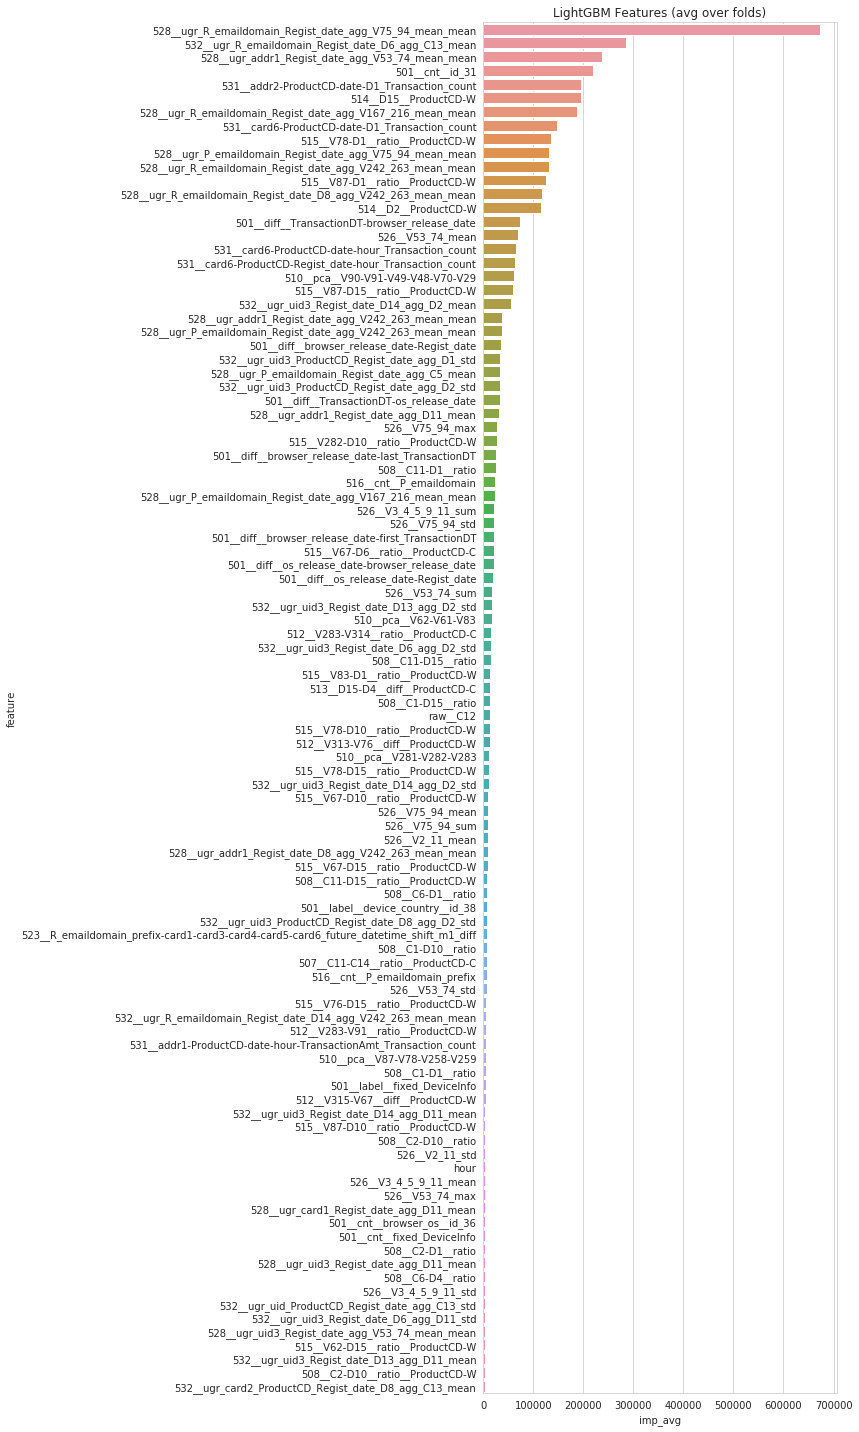

In [4]:
is_adv = [True, False][0]
is_submit = [True, False][0]
n_splits = 6
set_type = 'new_set'

valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

if len(valid_paths_train):
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
else:
    tmp_train = df_train
    tmp_test = df_test

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'

### DT-M
# group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
# group = read_pkl_gzip(group_kfold_path)
# tmp_train[COLUMN_GROUP] = group

# tmp_train[COLUMN_GROUP] = tmp_train['528__ugr_uid3_Regist_date_agg_V95_137_mean_mean'].fillna(0)

#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 60,
    'n_jobs': 96,
#     'n_jobs': 84,
#     'n_jobs': 48,
#     'n_jobs': 36,
    'objective': 'binary',
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.7,
    'subsample_freq': 1,
    'colsample_bytree' : 0.50,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
    "seed": 1208,
    "bagging_seed": 1208,
    "feature_fraction_seed": 1208,
    "drop_seed": 1208,
    'n_splits': n_splits,
    'metric': 'auc',
    'model_type': model_type,
    'fold': ['stratified', 'group'][0],
}
if is_submit:
    params['learning_rate'] = 0.01
    params['learning_rate'] = 0.05
    params['learning_rate'] = 0.1
#     params["early_stopping_rounds"] = 100

logger.info(f"* EXP: dataset {set_type} {tmp_train.shape} lr {params['learning_rate']} ")
            
if is_adv:
    Y = []
else:
    Y = df_train[COLUMN_TARGET]
    del df_train[COLUMN_TARGET]
            
feim, test_preds = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=is_adv,
    is_viz=[True, False][0],
)

In [25]:
#========================================================================
# Bear's ID
#========================================================================
data = pd.concat([df_train, df_test], axis=0)
col_bear = 'user_id_bear'
data.columns = [col.replace('ker__', '') for col in data.columns]

data.set_index(COLUMN_ID, inplace=True)
df_user_id_bear = pd.read_csv('../output/same_user_pattern/20190901_user_ids_share.csv').set_index(COLUMN_ID)
data[col_bear] = df_user_id_bear['predicted_user_id']

max_id = data[col_bear].max()

data.loc[data[data[col_bear].isnull()].index, col_bear] = np.arange(data[data[col_bear].isnull()].shape[0]) + max_id+1
data.reset_index(inplace=True)
data[col_bear] = data[col_bear].astype('int')
data[col_bear].head()

0    241400
1    241401
2     44469
3    237055
4    241402
Name: user_id_bear, dtype: int64

In [26]:
#========================================================================
# Bear's score
#========================================================================

from sklearn.metrics import roc_auc_score
bear = pd.read_csv('../input/20190913_ieee__bear_probing.csv').iloc[:, [0, 1, 2, 3, 4, 6]]
# bear = bear[bear[COLUMN_TARGET]==-1]
bear = bear.iloc[:, [0,1,2,3,5]]
bear.columns = [COLUMN_ID, COLUMN_DT, col_bear, 'data_type', 'bear_probing']
bear = bear.merge(data[[COLUMN_ID, 'DT-M']], how='inner', on=COLUMN_ID)
submission = pd.read_csv('../input/sample_submission.csv')
submission.columns = [COLUMN_ID, 'pred']


def bear_validation(test_pred):
    submission['pred'] = test_pred
    bear_score = submission.merge(bear, how='inner', on=COLUMN_ID)
    public  = bear_score[bear_score['data_type']=='test_public']
    private = bear_score[bear_score['data_type']=='test_private']
    
    public_score = roc_auc_score(public[COLUMN_TARGET].values, public['pred'].values)
    private_score = roc_auc_score(private[COLUMN_TARGET].values, private['pred'].values)
    all_score = roc_auc_score(bear_score[COLUMN_TARGET].values, bear_score['pred'].values)

    return public_score, private_score, all_score

In [35]:
#========================================================================
# Join Prediction
#========================================================================
pred = read_pkl_gzip('../output/pred_result/20190925_1450__CV0-9581588018233685__all_preds.gz').iloc[:, 1].values
data['pred_holy'] = pred
oof_haku = pd.read_csv('../output/oof/oof.csv').iloc[:, 1].values
test_haku = pd.read_csv('../output/oof/submission.csv').iloc[:, 1].values
data['pred_haku'] = np.hstack((oof_haku, test_haku))

oof_hmd = pd.read_csv('../output/oof/20190925_hmdhmd_oof.csv').iloc[:, 1].values
test_hmd = pd.read_csv('../output/oof/20190925_hmdhmd_pred.csv').iloc[:, 1].values
data['pred_hmd'] = np.hstack((oof_hmd, test_hmd))

oof_bear = pd.read_csv('../output/oof/20190925_all_uid_agg_stats_lr001_oof_features1381_oof0.95_pub0.984_pri0.989.csv')
test_bear = pd.read_csv('../output/oof/20190925_all_uid_agg_stats_lr001_pred_features1381_oof0.95_pub0.984_pri0.989.csv')
df_bear = pd.concat([oof_bear, test_bear], axis=0)
df_bear.columns = [COLUMN_ID, 'pred_bear']
data = data.merge(df_bear, how='inner', on=COLUMN_ID)

In [36]:
#========================================================================
# 検証するbear's idでfilter
#========================================================================
data.sort_values(by=COLUMN_DT, inplace=True)
bear_first = data.groupby(col_bear)['DT-M'].first()
bear_cnt = data.groupby(col_bear)['DT-M'].count()

bear_test_user = bear_first[bear_first>='2018-7'].index
bear_multi_cnt_user = bear_cnt[bear_cnt>3].index
bear_valid_user = list(set(bear_test_user) & set(bear_multi_cnt_user))
print(len(bear_valid_user))

df_bear_valid = bear[bear[col_bear].isin(bear_valid_user)]
df_bear_valid = df_bear_valid.merge(data[[COLUMN_ID, 'pred_holy', 'pred_haku', 'pred_hmd', 'pred_bear']], how='inner', on=COLUMN_ID)

13180


In [51]:
pd.set_option('max_rows', 1400)
df_bear_valid.sort_values(by=[col_bear, COLUMN_DT], ascending=False)

,TransactionID,TransactionDT,user_id_bear,data_type,isFraud,DT-M,pred_holy,pred_haku,pred_hmd,pred_bear
190,3933554,2018-10-18 5:09:27,238973,test_private,0.0,2018-10,0.027210,0.020968,0.009294,0.000879
189,3915469,2018-10-11 10:07:44,238973,test_private,0.0,2018-10,0.019129,0.022850,0.016690,0.003033
188,3882529,2018-09-28 22:03:44,238973,test_private,0.0,2018-9,0.025446,0.018590,0.008547,0.000594
187,3860721,2018-09-19 15:39:37,238973,test_private,0.0,2018-9,0.018457,0.013923,0.007723,0.035967
186,3860719,2018-09-19 15:38:43,238973,test_private,0.0,2018-9,0.021479,0.015444,0.007262,0.037597
185,3844129,2018-09-12 16:31:15,238973,test_private,0.0,2018-9,0.028101,0.021953,0.009433,0.000312
184,3838344,2018-09-09 21:59:57,238973,test_private,0.0,2018-9,0.029251,0.023227,0.007123,0.000399
183,3805061,2018-08-27 19:30:09,238973,test_private,0.0,2018-8,0.019223,0.017302,0.006491,0.001300
182,3805056,2018-08-27 19:26:54,238973,test_private,0.0,2018-8,0.020172,0.017664,0.006688,0.000374
181,3805054,2018-08-27 19:26:09,238973,test_private,0.0,2018-8,0.022810,0.017498,0.006284,0.000804


In [40]:
# feim = read_pkl_gzip('../output/feature_importances/20190925_1450__CV0-9581588018233685__feature2114.gz')
# feim.sort_values(by='imp_avg', ascending=False, inplace=True)
# feim = feim.reset_index()
# # cols_ugr = list(set([col for col in feim.index if col.count('ugr')]) - set(data.columns))
# cols_ugr = [col for col in data.columns if col.count('ugr')]
# feim = feim[feim['feature'].isin(cols_ugr)]
# cols_check = [col for col in feim['feature'].values if col.count('ugr')]

# cols_pred = sorted([col for col in data.columns if col.count('pred_')])

In [43]:
data[data[col_bear]==176579][[COLUMN_ID, col_bear, 'datetime', COLUMN_TARGET] + cols_pred + cols_check]

,TransactionID,user_id_bear,datetime,isFraud,pred_bear,pred_haku,pred_hmd,pred_holy,528__ugr_R_emaildomain_C1_C14_ratio_agg_V35_52_mean_mean,528__ugr_addr1_C1_C14_ratio_agg_D11_mean,...,532__ugr_uid3_Regist_date_D13_agg_C2_mean,532__ugr_uid3_ProductCD_Regist_date_D8_agg_D11_std,532__ugr_uid3_ProductCD_Regist_date_agg_C1_std,532__ugr_uid3_Regist_date_D6_agg_D11_std,528__ugr_uid3_Regist_date_agg_D11_mean,532__ugr_uid3_ProductCD_Regist_date_agg_D8_mean,532__ugr_uid3_Regist_date_D14_agg_C2_mean,532__ugr_uid3_ProductCD_Regist_date_D8_agg_C11_mean,532__ugr_uid3_Regist_date_D6_agg_C8_mean,532__ugr_uid3_ProductCD_Regist_date_agg_C4_mean
546938,3533938,176579,2018-05-17 00:21:05,NaN,0.007573,0.021267,0.038694,0.010689,0.922614,139.795624,...,45.352940,NaN,1.527525,NaN,NaN,25.029514,1.666667,1.857143,25.260870,20.000000
547100,3534100,176579,2018-05-17 01:16:13,NaN,0.015451,0.018413,0.025504,0.021017,0.922614,139.795624,...,45.352940,NaN,1.527525,NaN,NaN,25.029514,1.000000,1.857143,25.260870,20.000000
547467,3534467,176579,2018-05-17 04:21:32,NaN,0.006974,0.010365,0.017243,0.014920,0.922614,139.795624,...,93.333336,NaN,22.565487,NaN,NaN,43.304165,89.500000,1.000000,25.344828,25.297297
547545,3534545,176579,2018-05-17 06:17:37,NaN,0.174266,0.209449,0.247163,0.210728,1.149457,82.800003,...,93.333336,NaN,22.565487,NaN,NaN,43.304165,89.500000,1.000000,25.344828,25.297297
547547,3534547,176579,2018-05-17 06:18:40,NaN,0.146692,0.223811,0.243645,0.187193,1.149457,82.800003,...,93.333336,NaN,22.565487,NaN,NaN,43.304165,89.500000,1.000000,25.344828,25.297297
547550,3534550,176579,2018-05-17 06:19:49,NaN,0.129217,0.211043,0.232522,0.184988,1.149457,82.800003,...,93.333336,NaN,22.565487,NaN,NaN,43.304165,89.500000,1.000000,25.344828,25.297297
547551,3534551,176579,2018-05-17 06:20:41,NaN,0.130641,0.238473,0.261705,0.196589,1.149457,82.800003,...,93.333336,NaN,22.565487,NaN,NaN,43.304165,89.500000,1.000000,25.344828,25.297297
549233,3536233,176579,2018-05-17 20:27:15,NaN,0.023962,0.076727,0.087875,0.141530,1.149457,82.800003,...,93.333336,NaN,22.565487,NaN,NaN,43.304165,1.000000,2.294118,25.344828,25.297297
558469,3545469,176579,2018-05-21 00:10:58,NaN,0.009553,0.020510,0.050702,0.029302,0.922614,139.795624,...,2.000000,NaN,1.527525,NaN,NaN,25.029514,2.000000,1.000000,40.200001,20.000000
724672,3797681,176579,2018-08-24 14:32:37,NaN,0.185361,0.220326,0.134137,0.133101,1.528035,0.000000,...,93.333336,NaN,22.565487,NaN,NaN,43.304165,89.500000,2.294118,25.344828,25.297297


In [107]:
# data = data.merge(bear[[COLUMN_ID, 'bear_probing']], on=COLUMN_ID, how='left')
# data[COLUMN_TARGET].fillna(-1, inplace=True)
cols_save = [col_bear, 'datetime', COLUMN_TARGET, 'bear_probing'] + cols_pred + cols_check
# tmp = data[data['528__ugr_R_emaildomain_C1_C14_ratio_agg_V35_52_mean_mean']>1.3][cols_save]
tmp = data[data['528__ugr_R_emaildomain_C1_C14_ratio_agg_V35_52_mean_mean']<0.5][cols_save]
tmp.sort_values(by=[col_bear, 'datetime'])
# tmp.groupby([COLUMN_TARGET, '528__ugr_R_emaildomain_C1_C14_ratio_agg_V35_52_mean_mean'])[cols_pred].mean().loc[0]
tmp.shape

(786, 93)

In [7]:
from sklearn.metrics import roc_auc_score
# tmp.to_csv('../output/0928_ieee__valid_user_id_leak_thresh0.5.csv', index=False)
# tmp = pd.read_csv('../output/0928_ieee__valid_user_id_leak_thresh0.5.csv')
tmp = tmp[tmp[COLUMN_TARGET]>=0]
y_train = tmp[COLUMN_TARGET].values
haku = tmp['pred_haku'].values
holy = tmp['pred_holy'].values
hmd = tmp['pred_hmd'].values
print(roc_auc_score(y_train, haku))
print(roc_auc_score(y_train, holy))
print(roc_auc_score(y_train, hmd))

0.99000999000999
0.9822677322677323
0.9792707292707293


In [39]:
df_corr = tmp[cols_pred + cols_ugr].corr()
df_corr.loc['pred_haku'].sort_values()

532__ugr_uid3_Regist_date_D13_agg_D5_mean                       -0.166321
532__ugr_uid3_Regist_date_D14_agg_D2_mean                       -0.133768
528__ugr_uid3_Regist_date_agg_D11_mean                          -0.121714
528__ugr_addr1_C1_C14_diff_agg_D13_mean                         -0.108767
532__ugr_uid3_ProductCD_Regist_date_agg_D8_mean                 -0.106465
532__ugr_uid3_ProductCD_Regist_date_D8_agg_D2_std               -0.098176
532__ugr_uid3_ProductCD_Regist_date_agg_D2_std                  -0.089102
532__ugr_uid3_Regist_date_D13_agg_C13_mean                      -0.063097
532__ugr_uid_Regist_date_D13_agg_C13_mean                       -0.060495
528__ugr_uid3_Regist_date_agg_C13_mean                          -0.059588
532__ugr_R_emaildomain_Regist_date_D6_agg_C13_mean              -0.058547
532__ugr_uid3_ProductCD_Regist_date_D8_agg_C13_mean             -0.055999
532__ugr_card2_ProductCD_Regist_date_D8_agg_C13_mean            -0.055577
532__ugr_uid_ProductCD_Regist_date_agg

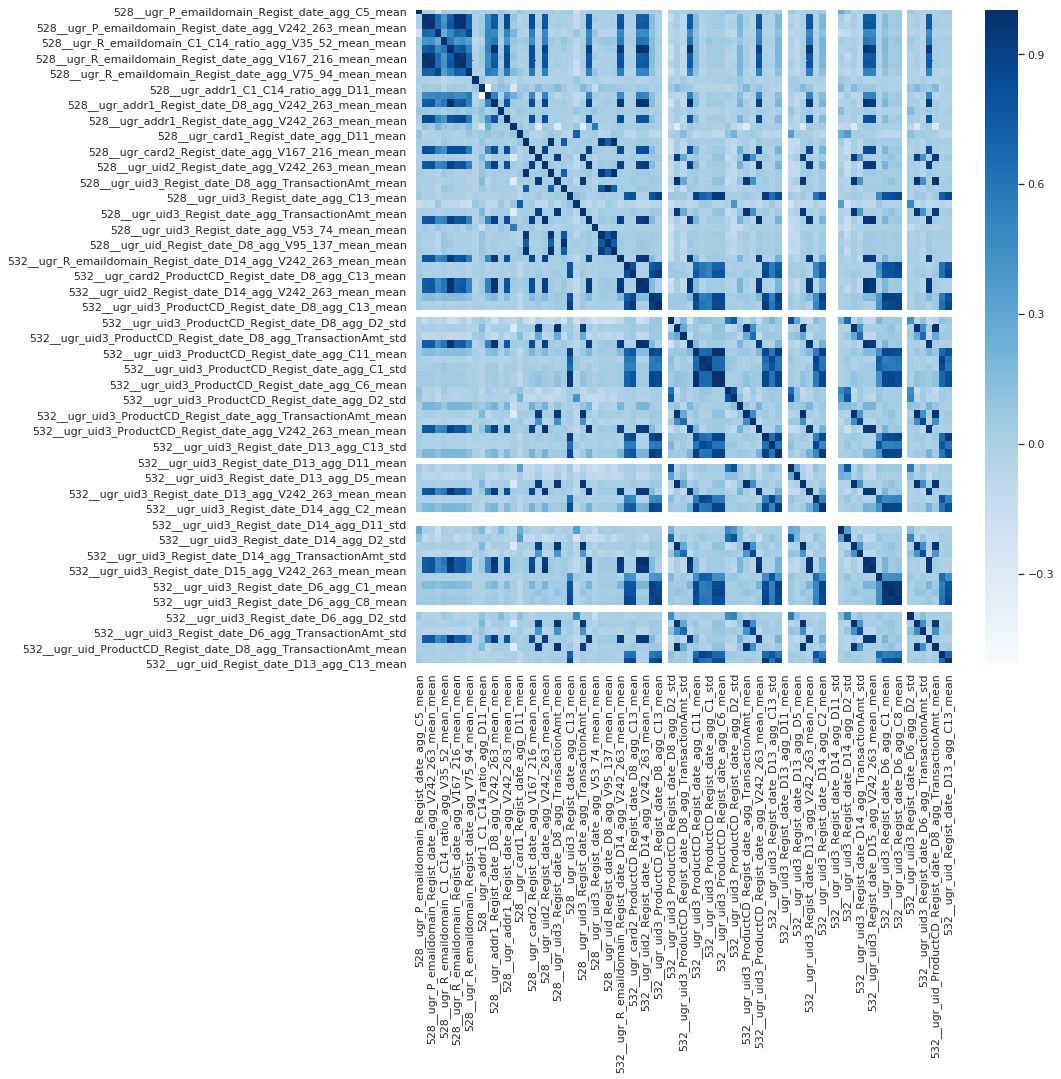

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 12))
sns.heatmap(df_corr, cmap='Blues')
plt.show()

In [23]:
cols_save = [col_bear, 'datetime', COLUMN_TARGET, 'bear_probing'] + cols_pred + cols_check
# data[data[col_bear]==29157][cols_save]
id_29157 = data[data[col_bear]==29157][COLUMN_ID]
data[data[col_bear]==203647][[COLUMN_ID] + cols_save].sort_values(by=COLUMN_ID)

NameError: name 'col_bear' is not defined

In [79]:
train_paths = glob('../feature/eda_base/*_train.gz')
test_paths = glob('../feature/eda_base/*_test.gz')
train_paths += glob('../feature/org_use/526*_train.gz')
test_paths  += glob('../feature/org_use/526*_test.gz')
train_paths += glob('../feature/raw_use/ker__uid*_train.gz')
test_paths  += glob('../feature/raw_use/ker__uid*_test.gz')

train_paths = [path for path in train_paths 
               if (path.count(COLUMN_DT) 
               or path.count(COLUMN_ID)
               or path.count(COLUMN_TARGET)
               or path.count('V')
               or path.count('C')
               or path.count('D')
               or (path.count('526') and path.count('mean'))
               or path.count('TransactionAmt')
               or path.count('Product')
               )
               and not path.count('fill')
               and not path.count('bin')
               and not path.count('129')
               and not path.count('130')
              ]
test_paths = [path for path in test_paths 
               if (path.count(COLUMN_DT) 
               or path.count(COLUMN_ID)
               or path.count(COLUMN_TARGET)
               or path.count('V')
               or path.count('C')
               or path.count('D')
               or (path.count('526') and path.count('mean'))
               or path.count('TransactionAmt')
               or path.count('Product')
               )
               and not path.count('fill')
               and not path.count('bin')
               and not path.count('129')
               and not path.count('130')
              ]

tmp_train = parallel_load_data(train_paths)
tmp_test = parallel_load_data(test_paths)
df_feat = pd.concat([tmp_train, tmp_test], axis=0, ignore_index=True)
del tmp_train, tmp_test
gc.collect()

7928

In [22]:
df_feat[df_feat[COLUMN_ID].isin([3407816a])]
# df_feat['round_526__V242_263_mean'] = df_feat['526__V242_263_mean'].map(lambda x: np.round(x, 1))
# df_feat.groupby('round_526__V242_263_mean')[COLUMN_TARGET].agg({
#     'mean': 'mean',
#     'count': 'count',
# })
# df_feat[df_feat[COLUMN_ID].isin([3407816])].sort_values(by=COLUMN_ID).set_index(COLUMN_ID)['ProductCD']

NameError: name 'df_feat' is not defined

In [117]:
data[data['DT-M']=='2018-12'].sort_values(by='528__ugr_R_emaildomain_C1_C14_ratio_agg_V35_52_mean_mean')[['528__ugr_R_emaildomain_C1_C14_ratio_agg_V35_52_mean_mean']+cols_pred]

,528__ugr_R_emaildomain_C1_C14_ratio_agg_V35_52_mean_mean,pred_bear,pred_haku,pred_hmd,pred_holy
1028072,0.461538,0.655073,0.009393,0.023279,0.013548
1030861,0.461538,0.000249,0.000291,0.002151,0.001192
1011307,0.461538,0.001378,0.041675,0.186312,0.061241
987426,0.461538,0.004345,0.001552,0.010758,0.006538
1028016,0.461538,0.001724,0.000374,0.002475,0.001287
1073328,0.461538,0.000090,0.220371,0.028543,0.056573
1073313,0.461538,0.004005,0.220679,0.021084,0.064006
1033412,0.461538,0.001145,0.014455,0.071793,0.130410
1092565,0.461538,0.015080,0.092677,0.035421,0.035408
1014289,0.461538,0.000798,0.000172,0.001432,0.000348
